In [53]:
from database import Database, LoadDatabase
from numba import njit, vectorize
import matplotlib.pyplot as plt
from atcoder import *
import numpy as np
import pickle
import os

os.environ['NUMBA_DISABLE_INTEL_SVML']  = '1'
CALCS_FILE = "calcs.pickle"

In [54]:
# if calculated and save before, load it from file
if os.path.exists(CALCS_FILE):
    with open(CALCS_FILE, "rb") as infile:
        print("Starting reading the file!")
        db, handle_to_id, id_to_handle, sorted_standings, handle_ids, ranks, standings_lens, user_contest_cnt = pickle.load(infile)
        print("File read!")
else:
    print("Starting calculations!")
    # load database
    db = LoadDatabase()

    # collect all handles in all standings
    all_handles = set()
    for standings in db.standings.values():
        for handle in standings.index:
            all_handles.add(handle)

    # create to way mappings (id, handle)
    handle_to_id = {handle: i for i, handle in enumerate(all_handles)}
    id_to_handle = {i: handle for handle, i in handle_to_id.items()}

    # sort standings by startTime
    sorted_standings = [(k, v) for k, v in sorted(db.standings.items(), key=lambda x: db.contests.loc[x[0]].startTime)]

    # merge handles, ranks and standings length into flat array
    handle_ids_merged = []
    ranks_merged = []
    standings_lengths_merged = []

    for c_id, standings in sorted_standings:
        standings = standings.sort_values("rank")
        for handle in standings.index:
            handle_ids_merged.append(handle_to_id[handle])
            ranks_merged.append(standings["rank"][handle])
        standings_lengths_merged.append(len(standings))

    # convert them to numpy array
    handle_ids = np.array(handle_ids_merged, dtype=np.int32)
    ranks = np.array(ranks_merged, dtype=np.int32)
    standings_lens = np.array(standings_lengths_merged, dtype=np.int32)
    user_contest_cnt = np.bincount(handle_ids)
    
    with open(CALCS_FILE, "wb") as outfile:
        obj = (db, handle_to_id, id_to_handle, sorted_standings, handle_ids, ranks, standings_lens, user_contest_cnt)
        pickle.dump(obj, outfile)
    
    print("Calculations ended!")

Starting reading the file!
File read!


In [61]:
CENTER = 1200
RATEDBOUND = np.inf

def get_first_K_contests(K):
    K_standings_len = np.sum(standings_lens[:K])
    K_handle_ids = handle_ids[:K_standings_len]
    K_ranks = ranks[:K_standings_len]
    K_standings_lens = standings_lens[:K]
    K_user_contest_cnt = np.bincount(K_handle_ids)
    return K_handle_ids, K_ranks, K_standings_lens, K_user_contest_cnt

@vectorize
def powersum(q, n):
    return q * (1 - q**n) / (1 - q)

@vectorize
def g(x):
    return np.power(2, x / 800)

@vectorize
def ginv(y):
    return 800 * np.log2(y)

@vectorize
def F(n):
    return np.sqrt(powersum(0.81, n)) / powersum(0.9, n)

@vectorize
def f(n):
    Finf = np.sqrt(0.81 / (1.0 - 0.81)) / (0.9 / (1.0 - 0.9))
    return (F(n) - Finf) / (F(1) - Finf) * CENTER

@njit
def calc(handle_ids, ranks, standings_lens, user_contest_cnt, verbose=True):
    user_cnt = len(user_contest_cnt)
    standings_cnt = len(standings_lens)
    history_cnt = len(handle_ids)
    
    nums = np.zeros(user_cnt, dtype=np.float64)
    dens = np.zeros(user_cnt, dtype=np.float64)
    aperfs = np.full(user_cnt, CENTER, dtype=np.float64)
    perfs = np.empty(history_cnt, dtype=np.float64)
    ratings = np.zeros(history_cnt, dtype=np.float64)
    offsets = np.cumsum(user_contest_cnt) - user_contest_cnt
    local_offsets = np.zeros(user_cnt, dtype=np.int32)
    ls = np.empty(np.max(standings_lens), dtype=np.float64)
    rs = np.empty(np.max(standings_lens), dtype=np.float64)
    cnts = np.empty(np.max(standings_lens), dtype=np.int32)
    handles = np.empty(np.max(standings_lens), dtype=np.int32)
    ls2 = np.empty_like(ls)
    rs2 = np.empty_like(rs)
    cnts2 = np.empty_like(cnts)
    handle_to_rank = np.empty(user_cnt, dtype=np.int32)
    
    standings_offset = 0
    standings_left = len(standings_lens)
    
    for i in range(standings_cnt):
        if verbose:
            print("Standings left:", standings_left)
        standings_left -= 1

        standings_len = standings_lens[i]
        for j in range(standings_len):
            handle_id = handle_ids[standings_offset + j]
            rank = ranks[standings_offset + j]
            handle_to_rank[handle_id] = rank
        
        ls[0] = 0
        rs[0] = 5000
        cnts[0] = standings_len
        handles[:standings_len] = handle_ids[standings_offset:standings_offset+standings_len]
        inters = 1
        inters2 = 0
        handles_cnt = 0
        max_iters = 80
        
        for j in range(max_iters):
            changed = False
            for k in range(inters):
                l = ls[k]
                r = rs[k]
                cnt = cnts[k]
                if (r - l) <= 1e-1:
                    ls2[inters2] = l
                    rs2[inters2] = r
                    cnts2[inters2] = cnt
                    handles_cnt += cnt
                    inters2 += 1
                else:
                    changed = True
                    m = (l + r) / 2
                    val = 0.0
                    for t in range(standings_len):
                        handle_id = handle_ids[standings_offset + t]
                        aperf = aperfs[handle_id]
                        val += 1 / (1 + np.power(6, (m - aperf) / 400))
                    lit, rit = handles_cnt, handles_cnt + cnt - 1
                    lefts, rights = 0, 0
                    while lit < rit:
                        lhandle_id = handles[lit]
                        lrank = handle_to_rank[lhandle_id]
                        if val <= lrank - 0.5:
                            lit += 1
                            lefts += 1
                            continue
                        rhandle_id = handles[rit]
                        rrank = handle_to_rank[rhandle_id]
                        if val > rrank - 0.5:
                            rit -= 1
                            rights += 1
                            continue
                        lefts += 1
                        rights += 1
                        handles[lit], handles[rit] = handles[rit], handles[lit]
                        lit += 1
                        rit -= 1
                    if lit == rit:
                        handle_id = handles[lit]
                        rank = handle_to_rank[handle_id]
                        if val <= rank - 0.5:
                            lefts += 1
                        else:
                            rights += 1
                    if lefts > 0:
                        ls2[inters2] = l
                        rs2[inters2] = m
                        cnts2[inters2] = lefts
                        inters2 += 1
                    if rights > 0:
                        ls2[inters2] = m
                        rs2[inters2] = r
                        cnts2[inters2] = rights
                        inters2 += 1
                    handles_cnt += cnt
            if changed == False:
                break
            inters = inters2
            for k in range(inters2):
                ls[k] = ls2[k]
                rs[k] = rs2[k]
                cnts[k] = cnts2[k]
            inters2 = 0
            handles_cnt = 0
            
        handles_cnt = 0
        for j in range(inters):
            perf_base = ls[j]
            cnt = cnts[j]
            for k in range(cnt):
                handle_id = handles[handles_cnt + k]
                offset = offsets[handle_id]
                local_offset = local_offsets[handle_id]
                if local_offset == 0:
                    perf = (perf_base - CENTER) * 1.5 + CENTER
                    ratings[offset + local_offset] = CENTER
                else:
                    perf = perf_base
                    den = dens[handle_id]
                    last_sum = g(ratings[offset + local_offset - 1]) * den
                    rperf = min(perfs[offset + local_offset - 1], RATEDBOUND + 400)
                    ratings[offset + local_offset] = ginv((0.9 * (last_sum + g(rperf))) / (0.9 * (1 + den)))
                perfs[offset + local_offset] = perf
                nums[handle_id] = 0.9 * (perf + nums[handle_id])
                dens[handle_id] = 0.9 * (1 + dens[handle_id])
                local_offsets[handle_id] += 1
            handles_cnt += cnt
        
        for j in range(standings_len):
            handle_id = handle_ids[standings_offset + j]
            aperfs[handle_id] = nums[handle_id] / dens[handle_id]
        
        standings_offset += standings_len
    
    return nums, dens, aperfs, perfs, ratings, offsets, local_offsets

In [66]:
# we will consider `consider` first standings
consider = 50

In [ ]:
# compile (jit)
compile_handle_ids, compile_ranks, compile_standings_lens, compile_user_contest_cnt = get_first_K_contests(5)
calc(compile_handle_ids, compile_ranks, compile_standings_lens, compile_user_contest_cnt, verbose=False)

# calculate
K_handle_ids, K_ranks, K_standings_lens, K_user_contest_cnt = get_first_K_contests(consider)
%time nums, dens, aperfs, perfs, ratings, offsets, local_offsets = \
    calc(K_handle_ids, K_ranks, K_standings_lens, K_user_contest_cnt)

for i in range(len(K_user_contest_cnt)):
    assert K_user_contest_cnt[i] == local_offsets[i]

Standings left: 500
Standings left: 499
Standings left: 498
Standings left: 497
Standings left: 496
Standings left: 495
Standings left: 494
Standings left: 493
Standings left: 492
Standings left: 491
Standings left: 490
Standings left: 489
Standings left: 488
Standings left: 487
Standings left: 486
Standings left: 485
Standings left: 484
Standings left: 483
Standings left: 482
Standings left: 481
Standings left: 480
Standings left: 479
Standings left: 478
Standings left: 477
Standings left: 476
Standings left: 475
Standings left: 474
Standings left: 473
Standings left: 472
Standings left: 471
Standings left: 470
Standings left: 469
Standings left: 468
Standings left: 467
Standings left: 466
Standings left: 465
Standings left: 464
Standings left: 463
Standings left: 462
Standings left: 461
Standings left: 460
Standings left: 459
Standings left: 458
Standings left: 457
Standings left: 456
Standings left: 455
Standings left: 454
Standings left: 453
<NULL> 452
<NULL> 451
<NULL> 450
<NULL> 

In [17]:
%time ans, userRatings = AtCoderRatingSystem(db, consider=consider, verbose=True)

Standings left: 250 contestId: 26
Standings left: 249 contestId: 27
Standings left: 248 contestId: 28
Standings left: 247 contestId: 29
Standings left: 246 contestId: 30
Standings left: 245 contestId: 31
Standings left: 244 contestId: 32


KeyboardInterrupt: 

In [68]:
def get_cf_ratings(handle):
    ans = []
    for contestId, standings in sorted_standings[:consider]:
        if handle in standings.index:
            ans.append(standings.loc[handle]["oldRating"])
    return ans

def get_random_user(user_contest_cnt, threshold=10):
    handle_ids = np.arange(len(user_contest_cnt))
    mask = user_contest_cnt > threshold
    handle_id = np.random.choice(handle_ids[mask])
    return id_to_handle[handle_id]

def plot_handle(handle, nums, dens, aperfs, perfs, ratings, offsets, user_contest_cnt):
    handle_id = handle_to_id[handle]
    contest_cnt = user_contest_cnt[handle_id]
    user_offset = offsets[handle_id]
    user_perfs = perfs[user_offset:user_offset+contest_cnt]
    user_ratings = ratings[user_offset:user_offset+contest_cnt]
    cf_ratings = get_cf_ratings(handle)
    assert len(user_perfs) == len(cf_ratings)
    assert len(user_ratings) == len(cf_ratings)
    print("number of contests", len(cf_ratings))
    xs = np.arange(len(cf_ratings))
    print(user_perfs)
    print(aperfs[handle_id])
    print(dens[handle_id])
    print(nums[handle_id])
    
    plt.figure(figsize=(15, 8))
    plt.plot(xs, user_ratings, label="AtCoder")
    plt.plot(xs, cf_ratings, label="CodeForces")
#     plt.plot(xs, user_perfs, label="AtCoderPerfs")
    plt.title(handle)
    plt.legend()
    plt.show()

number of contests 108
[-349.48883057  223.08349609  894.54650879 1156.23474121 1122.89428711
    0.         1282.80639648 1306.68640137 1367.34008789  801.16271973
 1649.01733398  761.94763184  563.50708008 1288.2232666  1649.5513916
  968.4753418   971.52709961 1905.1361084   878.60107422 1161.88049316
 1637.11547852  687.33215332 1475.21972656 1964.03503418 1504.13513184
 1507.9498291  1325.83618164 1591.87316895 1033.17260742 1224.97558594
 1579.05578613 1928.25317383 1360.24475098 2184.2956543  1036.75842285
  836.02905273 2171.55456543 1614.99023438 1363.83056641 2012.10021973
 1339.18762207 1476.74560547 1648.33068848 2091.82739258 1196.89941406
  943.37463379 1168.21289062 2092.05627441 1031.9519043  1450.72937012
 1421.20361328 1896.43859863 1669.54040527 1766.12854004 1066.58935547
 1539.38293457 1892.70019531 1986.77062988 1953.73535156 1911.46850586
 1580.27648926 1202.16369629 1853.17993164 2114.41040039 1932.52563477
 1763.15307617 2571.33483887 1926.87988281 1857.2235107

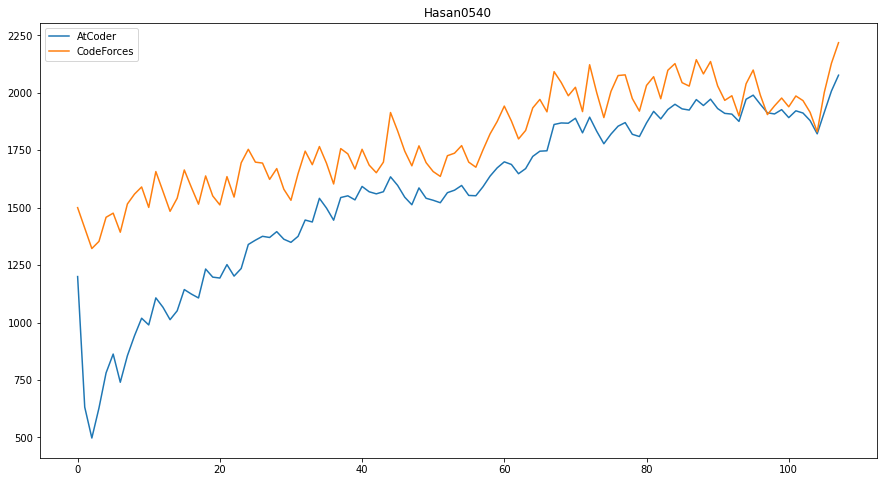

In [87]:
handle = get_random_user(K_user_contest_cnt, threshold=30)
# handle = "PAG"
plot_handle(handle, nums, dens, aperfs, perfs, ratings, offsets, K_user_contest_cnt)